#### Here, we compute the nearest neighbour features based on items text name. Within each category, we use item name to decide similarity among items. We know that 'std_dollar_value' and last k month sum sales are the important features for items and therefore we create Nearest Neighbor features for them. Hope is that performance for new items will improve with this.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostRegressor
from catboost import Pool
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import re
import os
print(os.listdir("../input"))

print(os.listdir("../input/itemnamesinenglish/"))
import gc

# Any results you write to the current directory are saved as output.

['addingzerototrain', 'itemnamesinenglish', 'fork-of-treebasedapproachdata', 'competitive-data-science-predict-future-sales']
['item_name.ru.en.txt']


In [2]:
OUTPUT_FPATH='NNDATA.hdf'

In [3]:
DATA_FPATH = '../input/fork-of-treebasedapproachdata/DATA.hdf'
TEST_LIKE_SALES_FPATH = '../input/addingzerototrain/train_with_zero.hdf'
SALES_FPATH ='../input/competitive-data-science-predict-future-sales/sales_train.csv'
ITEMS_FPATH = '../input/competitive-data-science-predict-future-sales/items.csv'
CATEGORIES_FPATH = '../input/competitive-data-science-predict-future-sales/item_categories.csv'
SHOPS_FPATH = '../input/competitive-data-science-predict-future-sales/shops.csv'
TEST_SALES_FPATH = '../input/competitive-data-science-predict-future-sales/test.csv'
SAMPLE_SUBMISSION_FPATH = '../input/competitive-data-science-predict-future-sales/sample_submission.csv'
TRAINED_MODEL_FPATH = 'trained_model.bin'

TEXT_FEATURE_FPATH = '../input/textfeatures/text_features.h5'

In [4]:
# Load preprocessed data.
X_df = pd.read_hdf(DATA_FPATH, 'X')
y_df = pd.read_hdf(DATA_FPATH, 'y')
test_X_df = pd.read_hdf(DATA_FPATH, 'test_X')

items_df = pd.read_csv(ITEMS_FPATH)
sales_df = pd.read_hdf(TEST_LIKE_SALES_FPATH)
item_names = open('../input/itemnamesinenglish/item_name.ru.en.txt','r').read().splitlines()

## Nearest neighbour code

In [5]:
"""
Nearest neighbour features. It should work well for those item_id's which are not present
in test data. This corresponds to new item_ids.
I've month, item_id, shop_id, item_category_id. So we can use features
only based on this.
"""
from multiprocessing import Pool
from typing import List, Tuple
from tqdm import tqdm_notebook, tqdm
from sklearn.neighbors import NearestNeighbors
# from multiprocessing import Pool
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# import cProfile, pstats

DEFAULT_VALUE = -10
CLUSTER_MONTH_WINDOW = 1


def tokenizer(s):
    tokens = re.split(' |-|/|:', s)
    tokens = [x.strip('[(*"./)]') for x in tokens]
    while '' in tokens:
        tokens.remove('')
    for word in ['and', 'for', 'of', 'the', '.', ',', '+']:
        while word in tokens:
            tokens.remove(word)

    return tokens


def get_existing_items(X_df, date_block_num):
    """
    Look at past 6 months excluding this date_block_num
    """
    dbns = list(range(date_block_num - CLUSTER_MONTH_WINDOW + 1, date_block_num + 1))
    old_items = ~X_df.orig_item_id_is_fm
    return set(X_df[(old_items) & (X_df.date_block_num.isin(dbns))].item_id.unique())


class NNModel:
    def __init__(self, item_ids_text_features, item_ids, n_neighbors, metric):
        self._item_ids = np.array(item_ids)
        self.model = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=4, algorithm='auto')
        self.model.fit(item_ids_text_features)

    def predict(self, item_id_text_feature) -> Tuple[List[List[int]], List[List[float]]]:
        """
        Returns:
            neigh_ids: array of neighbor item_ids
        """
        NN_output = self.model.kneighbors(item_id_text_feature)
        neighs = NN_output[1]
        # getting item_ids
        neigh_ids = [list(self._item_ids[id_set]) for id_set in neighs]

        neighs_dist = [list(a) for a in NN_output[0]]

        # ensuring that distances lie within [0,1]
        assert all(min(a) >= 0 for a in neighs_dist), min([min(a) for a in neighs_dist])

        return (neigh_ids, neighs_dist)


class NNModels:
    """
    Create NN models for each category, date_block_num
    """

    def __init__(self, items_text_data, sales_df, items_df, n_neighbors):
        # for each category, learn a nearest neighbour on a rolling basis.
        self._metric = 'minkowski'
        self._items_text = items_text_data
        self._items = items_df
        self._n_neighbors = n_neighbors

        sales_df = pd.merge(sales_df, self._items, on='item_id', how='left')
        self._category_to_item_ids = sales_df.groupby('item_category_id')['item_id'].apply(set).to_dict()
        self.neighbors = {}

    def run(self, X_df):
        for dbn in range(35):
            self.neighbors[dbn] = {}
            item_ids = get_existing_items(X_df[['item_id', 'date_block_num', 'orig_item_id_is_fm']], dbn)
            for item_category_id in self._category_to_item_ids:
                self.neighbors[dbn][item_category_id] = None
                cat_item_ids = list(item_ids.intersection(self._category_to_item_ids[item_category_id]))

                if len(cat_item_ids) == 0:
                    continue

                X = self._items_text[cat_item_ids]
                model = NNModel(X, cat_item_ids, min(self._n_neighbors, X.shape[0]), self._metric)
                self.neighbors[dbn][item_category_id] = model


def get_item_shop_dbn_id(item_id, shop_id, date_block_num):
    return item_id * 100 * 35 + shop_id * 35 + date_block_num


def get_item_dbn_id(item_id, date_block_num):
    return item_id * 35 + date_block_num


def add_item_shop_dbn_id(df):
    df['item_shop_dbn_idx'] = get_item_shop_dbn_id(df['item_id'], df['shop_id'], df['date_block_num'])


def add_item_dbn_id(df):
    df['item_dbn_idx'] = get_item_dbn_id(df['item_id'], df['date_block_num'])


def get_nn_features_data(X_df, feature_col):
    item_features = X_df.groupby(['item_id', 'date_block_num'])[[feature_col]].mean().reset_index()
    shop_item_features = X_df[['item_id', 'shop_id', 'date_block_num', feature_col]].copy()

    # create index
    add_item_shop_dbn_id(shop_item_features)
    shop_item_features.set_index('item_shop_dbn_idx', inplace=True)

    add_item_dbn_id(item_features)
    item_features.set_index('item_dbn_idx', inplace=True)
    return (shop_item_features[feature_col].to_dict(), item_features[feature_col].to_dict())


def get_neighbor_item_ids(
        date_block_num,
        item_category_id,
        item_ids,
        neighbors,
        items_text_data,
):
    model = neighbors[date_block_num][item_category_id]
    if model is None:
        return [[]] * len(item_ids)

    text_features = items_text_data[item_ids]

    neighbor_item_ids, neighbor_item_ids_dist = model.predict(text_features)
    for idx, item_id in enumerate(item_ids):
        if item_id in neighbor_item_ids[idx]:
            same_item_id_idx = neighbor_item_ids[idx].index(item_id)
            del neighbor_item_ids[idx][same_item_id_idx]
            del neighbor_item_ids_dist[idx][same_item_id_idx]
            # neighbor_item_ids[idx].remove(item_id)

    return [list(zip(neighbor_item_ids[i], neighbor_item_ids_dist[i])) for i in range(len(item_ids))]


def compute_weights(distance_arr):
    assert len(distance_arr) > 1
    # In general, distances have 1 as the maximum value.
    distance_arr = [w / max(1, max(distance_arr)) for w in distance_arr]
    weights = [1 - w for w in distance_arr]

    sm = sum(weights)
    if sm != 0:
        weights = [w / sm for w in weights]
    else:
        # here all distances are same. If they are less then equally allocate them. for large distances, treat them as
        # noise.
        if distance_arr[0] > 0.9:
            # random points getting treated as neighbors.
            weights = [np.nan] * len(weights)
        else:
            weights = [1 / len(weights)] * len(weights)

    return np.array(weights)


def _get_one_row_feature(
        date_block_num,
        shop_id,
        shop_item_features,
        item_features,
        neighbors,
        n_neighbors,
        use_weights=False,
):
    feature = np.zeros(len(neighbors))
    neighbor_item_ids, neighbor_distances = zip(*neighbors)
    # neighbor_weights = [1 - a for a in neighbor_distances]

    for i, n_item_id in enumerate(neighbor_item_ids):
        item_shop_dbn_id = get_item_shop_dbn_id(n_item_id, shop_id, date_block_num)
        if item_shop_dbn_id in shop_item_features:
            feature[i] = shop_item_features[item_shop_dbn_id]
        else:
            item_dbn_id = get_item_dbn_id(n_item_id, date_block_num)
            assert item_dbn_id in item_features, '{}-{} item_dbn_id not present '.format(n_item_id, date_block_num)
            feature[i] = item_features[item_dbn_id]

    # for one length neighbors, weights does not make sense.
    if use_weights and len(neighbor_item_ids) > 1:
        output = [0] * len(n_neighbors)
        for i, neighbor_count in enumerate(n_neighbors):
            if neighbor_count ==1:
                weights = 1
            else:
                weights = compute_weights(neighbor_distances[:neighbor_count])
            output[i] = np.sum(feature[:neighbor_count] * weights)

        return output

    return [np.mean(feature[:n]) for n in n_neighbors]


def get_one_dbn_category_feature(
        date_block_num,
        item_category_id,
        item_ids,
        shop_ids,
        shop_item_features,
        item_features,
        neighbors,
        items_text_data,
        n_neighbors,
        use_weights=False,
):
    output = np.ones((len(shop_ids), len(n_neighbors))) * DEFAULT_VALUE
    neighbor_item_ids = get_neighbor_item_ids(date_block_num, item_category_id, item_ids, neighbors, items_text_data)
    for i, shop_id_neighbors in enumerate(zip(shop_ids, neighbor_item_ids)):
        shop_id, neighbors = shop_id_neighbors
        if len(neighbors) == 0:
            continue
        output[i, :] = _get_one_row_feature(
            date_block_num, shop_id, shop_item_features, item_features, neighbors, n_neighbors, use_weights=use_weights)
    return output


def set_nn_feature(
        X_df,
        feature_col,
        items_text_data,
        sales_df,
        items_df,
        n_neighbors: List[int],
        use_weights=False,
):
    assert 'orig_item_id_is_fm' in X_df
    assert 'item_category_id' in X_df
    assert 'item_id' in X_df
    assert 'date_block_num' in X_df
    assert feature_col in X_df

    # create models for getting neighbor item_ids
    # sometimes, we need to remove the item_id from nearest neighbors. So 1 takes care of it.
    models = NNModels(items_text_data, sales_df, items_df, 1 + max(n_neighbors))
    models.run(X_df)
    print('Models created')

    # get features for item ids.
    (shop_item_features, item_features) = get_nn_features_data(X_df, feature_col)
    print('Features computed')

    features = np.zeros((X_df.shape[0], len(n_neighbors)))
    index = np.zeros(X_df.shape[0])
    features_idx = 0
    for dbn in tqdm_notebook(range(35)):
        dbn_X_df = X_df[X_df.date_block_num == dbn]
        for item_category_id in range(84):
            temp_X = dbn_X_df[dbn_X_df.item_category_id == item_category_id]

            if temp_X.empty:
                continue

            one_block_data = get_one_dbn_category_feature(
                dbn,
                item_category_id,
                temp_X.item_id.values,
                temp_X.shop_id.values,
                shop_item_features,
                item_features,
                models.neighbors,
                items_text_data,
                n_neighbors,
                use_weights=use_weights,
            )
            features[features_idx:features_idx + one_block_data.shape[0], :] = one_block_data
            index[features_idx:features_idx + one_block_data.shape[0]] = temp_X.index.tolist()
            features_idx += one_block_data.shape[0]

    for i, neighbor_sz in enumerate(n_neighbors):
        col = '{}Neighbor_{}'.format(neighbor_sz, feature_col)
        X_df[col] = pd.Series(features[:, i], index=index).astype(np.float32)
        print('Invalid entries fraction for', col, X_df[col].isna().sum() / X_df.shape[0])
        X_df[col].fillna(-10, inplace=True)



### Generating text features 

In [6]:
tf = TfidfVectorizer(tokenizer=tokenizer, min_df=0.0003)
items_text_data = tf.fit_transform(item_names)
len(tf.get_feature_names())

2640

## Feeding generated text features to Nearest Neighbour as input to get neighbours and then NN features.

In [7]:
def add_nn_features(X_df, n_neighbor_list, feature_col, use_weights):    
    X_minimal_df = X_df[['date_block_num','item_id','shop_id','item_category_id','orig_item_id_is_fm',feature_col]].copy()
    X_minimal_df[['date_block_num','item_id','shop_id']]=X_minimal_df[['date_block_num','item_id','shop_id']].astype(np.int32)
    set_nn_feature(X_minimal_df,feature_col,items_text_data,sales_df,items_df,n_neighbor_list,use_weights=use_weights)
    for n_neighbors in n_neighbor_list:
        new_feature= '{}Neighbor_{}'.format(n_neighbors, feature_col)
        X_df[new_feature] = X_minimal_df[new_feature]

In [8]:
orig_cols = X_df.columns.tolist()

## Feature computation for 'std_dollar_value'

In [9]:
feature_col = 'std_dollar_value'
n_neighbors_list = [1,2,6]
use_weights = False

In [10]:
add_nn_features(X_df, n_neighbors_list, feature_col, use_weights)
add_nn_features(test_X_df, n_neighbors_list, feature_col, use_weights)

Models created
Features computed



Invalid entries fraction for 1Neighbor_std_dollar_value 0.0
Invalid entries fraction for 2Neighbor_std_dollar_value 0.0
Invalid entries fraction for 6Neighbor_std_dollar_value 0.0
Models created
Features computed



Invalid entries fraction for 1Neighbor_std_dollar_value 0.0
Invalid entries fraction for 2Neighbor_std_dollar_value 0.0
Invalid entries fraction for 6Neighbor_std_dollar_value 0.0


## Feature computation for 'item_cnt_day_2M_sum'

In [11]:
feature_col='item_cnt_day_2M_sum'
n_neighbors_list = [1,2,6]
use_weights = False

In [12]:
add_nn_features(X_df, n_neighbors_list, feature_col, use_weights)
add_nn_features(test_X_df, n_neighbors_list, feature_col, use_weights)

Models created
Features computed



Invalid entries fraction for 1Neighbor_item_cnt_day_2M_sum 0.0
Invalid entries fraction for 2Neighbor_item_cnt_day_2M_sum 0.0
Invalid entries fraction for 6Neighbor_item_cnt_day_2M_sum 0.0
Models created
Features computed



Invalid entries fraction for 1Neighbor_item_cnt_day_2M_sum 0.0
Invalid entries fraction for 2Neighbor_item_cnt_day_2M_sum 0.0
Invalid entries fraction for 6Neighbor_item_cnt_day_2M_sum 0.0


## Feature computation for 'item_cnt_day_1_sum'

In [13]:
feature_col='item_cnt_day_1M_sum'
n_neighbors_list = [1,2,6]
use_weights = False

In [14]:
add_nn_features(X_df, n_neighbors_list, feature_col, use_weights)
add_nn_features(test_X_df, n_neighbors_list, feature_col, use_weights)

Models created
Features computed



Invalid entries fraction for 1Neighbor_item_cnt_day_1M_sum 0.0
Invalid entries fraction for 2Neighbor_item_cnt_day_1M_sum 0.0
Invalid entries fraction for 6Neighbor_item_cnt_day_1M_sum 0.0
Models created
Features computed



Invalid entries fraction for 1Neighbor_item_cnt_day_1M_sum 0.0
Invalid entries fraction for 2Neighbor_item_cnt_day_1M_sum 0.0
Invalid entries fraction for 6Neighbor_item_cnt_day_1M_sum 0.0


## Write the features to file.

In [15]:
X_df.to_hdf(OUTPUT_FPATH, 'X')
y_df.to_hdf(OUTPUT_FPATH, 'y')
test_X_df.to_hdf(OUTPUT_FPATH, 'test_X')

## Looking at the correlation between newly created features

In [16]:
new_cols = list(set(X_df.columns.tolist()) - set(orig_cols))

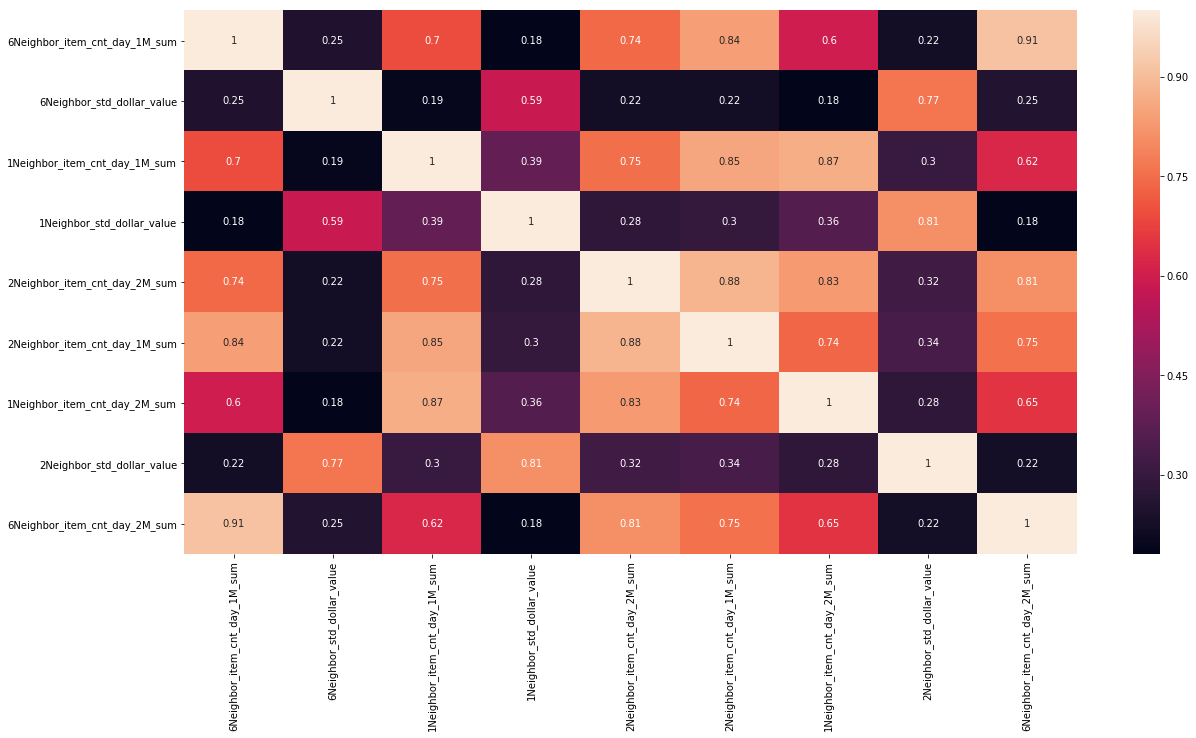

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax= plt.subplots(figsize=(20,10))
corr = X_df[new_cols].corr()
sns.heatmap(corr, ax=ax, annot=True)

## Correlation plot on test data

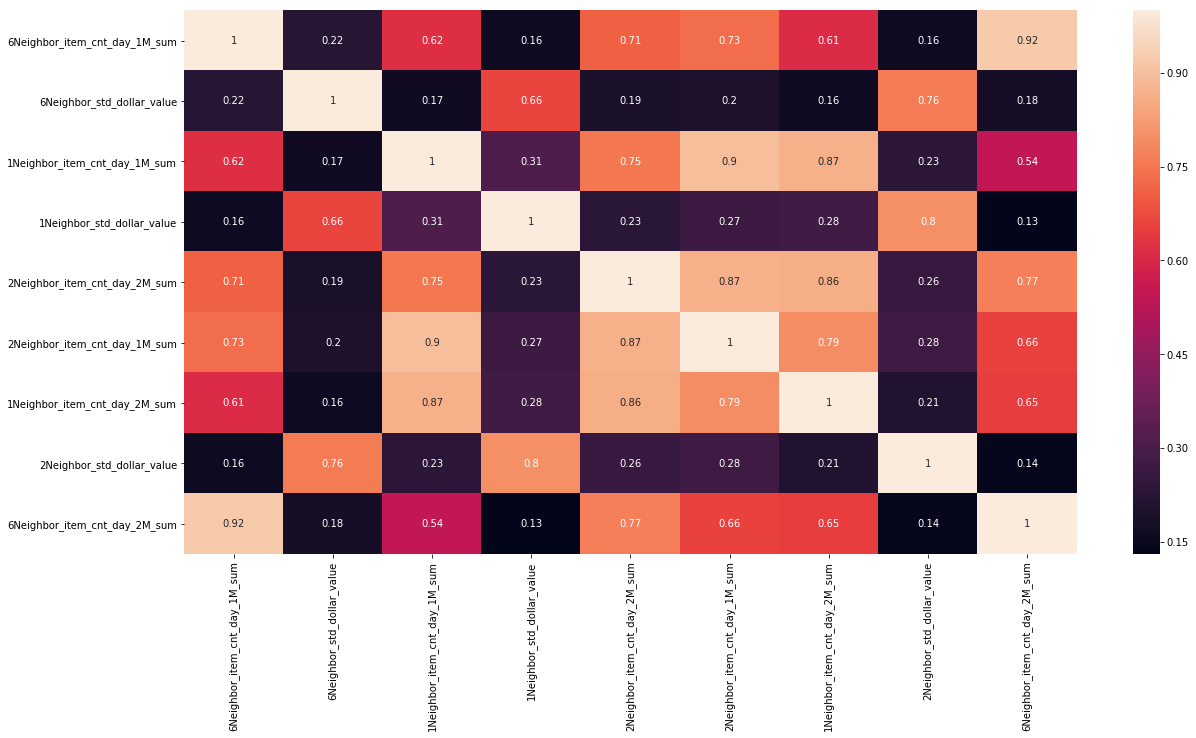

In [18]:
_, ax= plt.subplots(figsize=(20,10))
corr_test = test_X_df[new_cols].corr()
sns.heatmap(corr_test, ax=ax, annot=True)

### Train Test correlation comparison

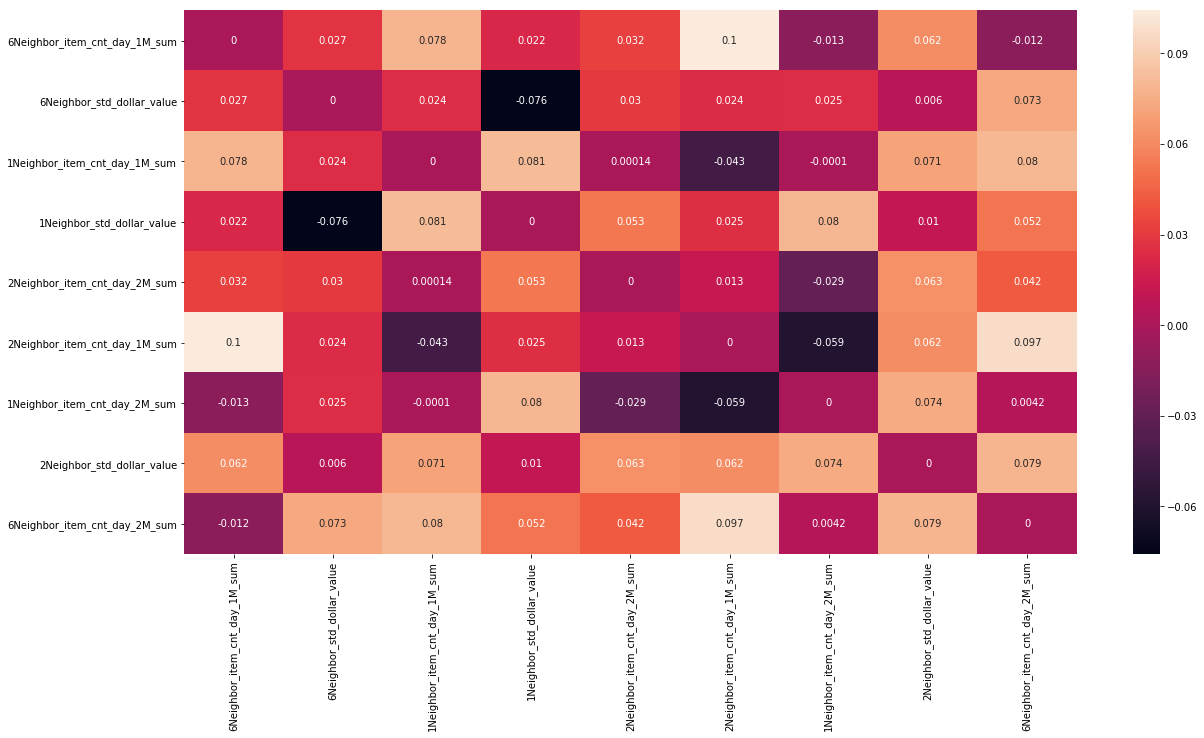

In [19]:
_, ax= plt.subplots(figsize=(20,10))
sns.heatmap(corr - corr_test, ax=ax, annot=True)
